In [1]:
import os
import sys

import numpy as np

module_path = os.path.abspath(os.path.join('...'))
if module_path not in sys.path:
    sys.path.append(module_path)

from instructor.environment import FindAllShapesEnv
from instructor.callback import IoUCallback
from datasets.shapes import generate_image

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'instructor'

In [2]:
# from datasets.shapes import Triangle
# 
# for i in range(5):
#     entry = generate_image(8, create_mask=False, combinations=[(Triangle, c) for c in ["red", "green", "blue", "purple"]], scale=60)
#     entry.image.save(f"triangles_{i}.png")

In [3]:
import random
import torch

SEED = 57

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
%%time
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import SubprocVecEnv

set_random_seed(SEED)
make_env = lambda: FindAllShapesEnv(lambda: generate_image(30, False, scale=1).shapes)
vec_env = make_vec_env(make_env, n_envs=1024)
model = DQN("MlpPolicy", vec_env, verbose=0,
            # gradient_steps=-1,
            device="cpu",
            # policy_kwargs={'net_arch': [64, 64]},
            tensorboard_log='tb_test'
            ).learn(450000, progress_bar=False, tb_log_name='dqn_base', 
                    callback=IoUCallback()
                    )

CPU times: user 7min 58s, sys: 2 s, total: 8min
Wall time: 7min 29s


In [5]:
ious = []
rewards = []
env = make_env()
set_random_seed(SEED)
obs = env.reset()
for _ in range(3000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        obs = env.reset()
        if 'iou' in info:
            ious.append(info['iou'])
print(f"Mean IoU: {np.mean(ious)}\nMean reward: {np.mean(rewards)}")

Mean IoU: 0.0
Mean reward: 0.11833333333333333


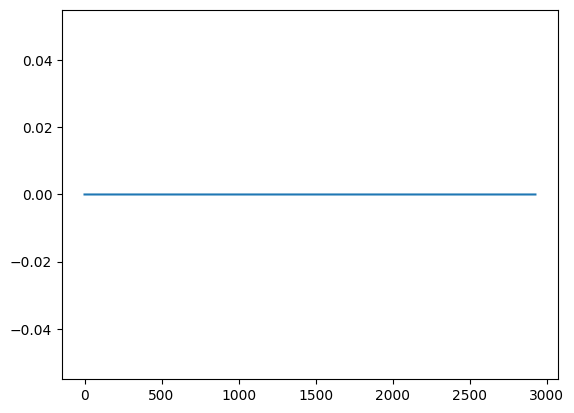

In [6]:
import matplotlib.pyplot as plt

plt.plot(ious)

In [7]:
# Test the trained agent
env = FindAllShapesEnv(lambda: generate_image(8, False, scale=1).shapes)
obs = env.reset()

print(", ".join(map(str, env.shapes)))

n_steps = 70
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print(f"Step {step + 1}")
    print("Action: ", env.action_dict[action.item()])
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break

Circle: red, Triangle: red, Triangle: blue, Square: blue, Triangle: red, Triangle: green, Triangle: red, Square: blue
Step 1
Action:  STOP
obs= [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] reward= 5 done= True

Current task: Find all red squares
No current shape
Extracted: 

Goal reached! reward= 5


In [8]:
model.policy

DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=5, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=18, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)